In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from gluonts.dataset.pandas import PandasDataset
from gluonts.torch import DeepAREstimator

from utils import M5Data

/home/ag6154lk/KISA_ITSDA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

## Data exploration

M5 Forecasting - Accuracy

In [2]:
data_root = "../data/m5-forecasting-accuracy" # Root dir of the M5 dataset

calendar = pd.read_csv(os.path.join(data_root, "calendar.csv"))
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
test = pd.read_csv(os.path.join(data_root, "sales_train_evaluation.csv"))
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [20]:
train = pd.read_csv(os.path.join(data_root, "sales_train_validation.csv"))
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


d_1    32631
d_2    31749
d_3    23783
d_4    25412
d_5    19146
dtype: int64

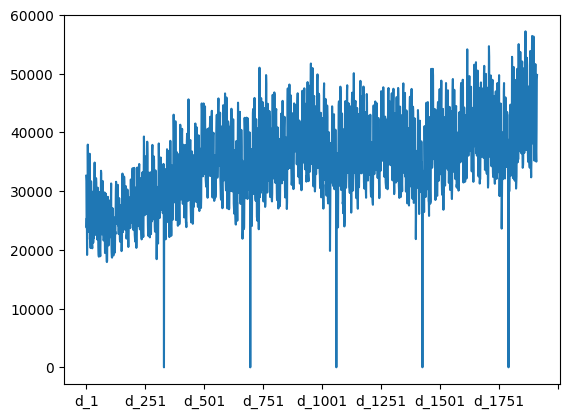

In [23]:
# Ventas totales por día
start_pos = train.columns.get_loc('d_1')

total_sales = train.iloc[:, start_pos:].sum()
total_sales.plot()
total_sales.head()
#total_sales[total_sales < 1000]

In [ ]:
calendar[calendar['d'] == "d_697"]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0


<Axes: >

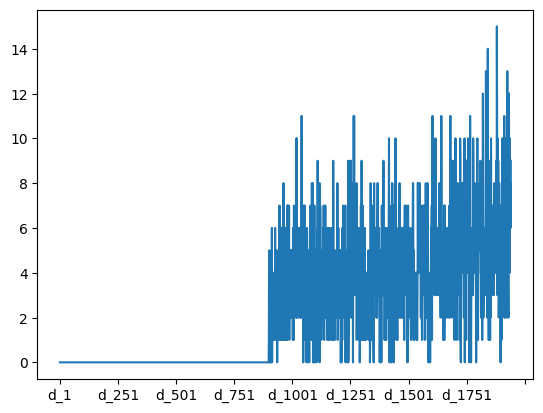

In [ ]:
train[train['item_id'] == "HOBBIES_1_001"].iloc[:, start_pos:].sum().plot()

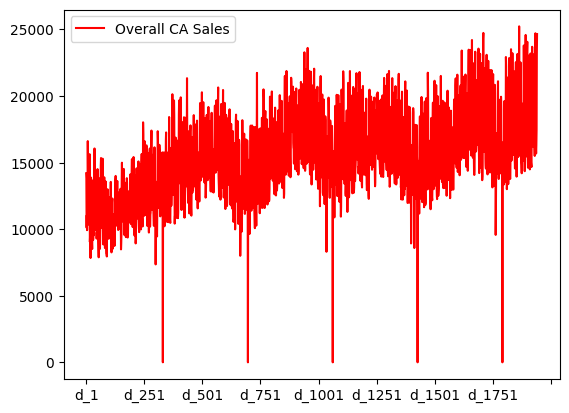

In [ ]:
train[train['state_id'] == "CA"].iloc[:, start_pos:].sum().plot(color="red", label = "Overall CA Sales")
#sales[sales['state_id'] == "TX"].iloc[:, start_pos:].sum().plot(color="blue", label = "Overall TX Sales")
#sales[sales['state_id'] == "WI"].iloc[:, start_pos:].sum().plot(color="green", label = "Overall WI Sales")
plt.legend()

## Data Loading

In [2]:
data_root = "../data/m5-forecasting-accuracy" # Root dir of the M5 dataset
calendar_path = os.path.join(data_root, "calendar.csv")
sales_train_validation_path = os.path.join(data_root, "sales_train_validation.csv")
sales_train_evaluation_path = os.path.join(data_root, "sales_train_evaluation.csv")

In [3]:
m5data = M5Data(calendar_path=calendar_path, 
                sales_train_validation_path=sales_train_validation_path,
                sales_train_evaluation_path=sales_train_evaluation_path)


<Figure size 640x480 with 0 Axes>

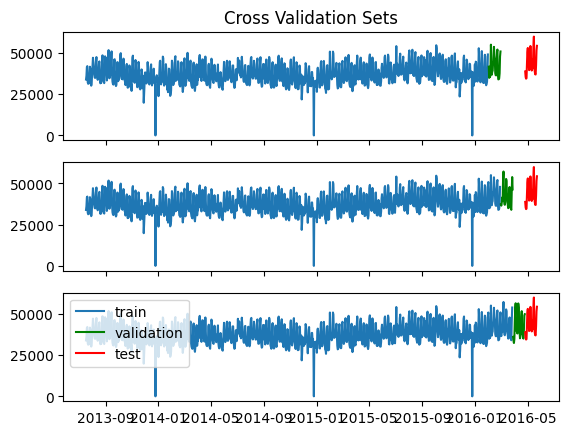

In [4]:
train_sets, cv_sets = m5data.get_train_val_ts(dynamic_start_pos=True)
test_set = m5data.get_test_ts()
n_splits = len(train_sets)

plt.tight_layout()
f, axs = plt.subplots(n_splits, 1, sharex=True)
axs[0].set_title("Cross Validation Sets")
for i in range(n_splits):
    train_ts= train_sets[i]
    cv_ts   = cv_sets[i]

    n_days = len(cv_ts)
    dates   = m5data.get_dates(pd.concat([train_ts, cv_ts]), real=True)
    test_dates = m5data.get_dates(test_set, real=True)

    axs[i].plot(dates.values[:-n_days], train_ts.values, label="train")
    axs[i].plot(dates.values[-n_days:], cv_ts.values, color="green", label="validation")
    axs[i].plot(test_dates.values, test_set.values, color="red", label="test")
plt.legend(loc="upper left")

In [6]:
m5data.sales_train[m5data.sales_train['item_id'] == "FOODS_3_823"]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
3044,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,4,0,2,1,0,2,0,4,1,1
6093,FOODS_3_823_CA_2_validation,FOODS_3_823,FOODS_3,FOODS,CA_2,CA,0,0,0,0,...,4,2,1,3,1,3,0,2,2,3
9142,FOODS_3_823_CA_3_validation,FOODS_3_823,FOODS_3,FOODS,CA_3,CA,10,5,4,5,...,2,2,2,3,3,2,3,4,1,0
12191,FOODS_3_823_CA_4_validation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,1,1,1,4,...,3,1,2,2,0,1,1,3,3,0
15240,FOODS_3_823_TX_1_validation,FOODS_3_823,FOODS_3,FOODS,TX_1,TX,2,2,2,2,...,0,1,0,0,0,0,0,0,1,0
18289,FOODS_3_823_TX_2_validation,FOODS_3_823,FOODS_3,FOODS,TX_2,TX,2,1,0,1,...,0,0,0,0,1,0,0,0,1,0
21338,FOODS_3_823_TX_3_validation,FOODS_3_823,FOODS_3,FOODS,TX_3,TX,0,0,0,0,...,1,1,0,1,0,0,0,2,0,2
24387,FOODS_3_823_WI_1_validation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,0,0,0,0,...,0,1,2,1,0,0,0,2,0,0
27436,FOODS_3_823_WI_2_validation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1


In [ ]:
m5data.sales_train['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

# DeepAR

In [29]:
train_sets, cv_sets = m5data.get_train_val_ts(n_splits=1, dynamic_start_pos=True)
test_set = m5data.get_test_ts()
# n_splits = len(train_sets)

training_dates = m5data.get_dates(train_sets[0])
training_df = pd.DataFrame({"sales": train_sets[0].values}, index=training_dates.values)
training_df.index.name = "Day" 
training_data = PandasDataset(training_df, freq="D", target="sales")
print(training_df)

eval_dates = m5data.get_dates(cv_sets[0])
eval_df = pd.DataFrame({"sales": cv_sets[0].values}, index=eval_dates.values)
eval_df.index.name = "Day" 
eval_data = PandasDataset(eval_df, freq="D", target="sales")
print(eval_df)

test_dates = m5data.get_dates(test_set)
test_df = pd.DataFrame({"sales": test_set.values}, index=test_dates.values)
test_df.index.name = "Day" 

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=28, freq="D", trainer_kwargs={"max_epochs": 5}
).train(training_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ag6154lk/KISA_ITSDA/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                         | Out sizes   
--------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1120, 4], [1, 1120], [1, 1120], [1, 28, 4]] | [1, 100, 28]
--------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)
11      

            sales
Day              
2013-07-18  33921
2013-07-19  36194
2013-07-20  41527
2013-07-21  42039
2013-07-22  32203
...           ...
2016-03-23  34786
2016-03-24  34003
2016-03-25  45611
2016-03-26  53863
2016-03-27  46360

[984 rows x 1 columns]
            sales
Day              
2016-03-28  36041
2016-03-29  33857
2016-03-30  32359
2016-03-31  34681
2016-04-01  45536
2016-04-02  52672
2016-04-03  56425
2016-04-04  40418
2016-04-05  39683
2016-04-06  39134
2016-04-07  38116
2016-04-08  43220
2016-04-09  56340
2016-04-10  53856
2016-04-11  42427
2016-04-12  39069
2016-04-13  35193
2016-04-14  37529
2016-04-15  41789
2016-04-16  48362
2016-04-17  51640
2016-04-18  38059
2016-04-19  37570
2016-04-20  35343
2016-04-21  35033
2016-04-22  40517
2016-04-23  48962
2016-04-24  49795
Epoch 0: |          | 50/? [00:02<00:00, 18.28it/s, v_num=17, train_loss=11.10]

Epoch 0, global step 50: 'train_loss' reached 11.09009 (best 11.09009), saving model to '/home/ag6154lk/KISA_ITSDA/TSF/lightning_logs/version_17/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:03<00:00, 16.44it/s, v_num=17, train_loss=10.10]

Epoch 1, global step 100: 'train_loss' reached 10.10482 (best 10.10482), saving model to '/home/ag6154lk/KISA_ITSDA/TSF/lightning_logs/version_17/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 18.74it/s, v_num=17, train_loss=9.840]

Epoch 2, global step 150: 'train_loss' reached 9.83719 (best 9.83719), saving model to '/home/ag6154lk/KISA_ITSDA/TSF/lightning_logs/version_17/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 16.74it/s, v_num=17, train_loss=9.500]

Epoch 3, global step 200: 'train_loss' reached 9.50350 (best 9.50350), saving model to '/home/ag6154lk/KISA_ITSDA/TSF/lightning_logs/version_17/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:03<00:00, 14.38it/s, v_num=17, train_loss=9.380]

Epoch 4, global step 250: 'train_loss' reached 9.38051 (best 9.38051), saving model to '/home/ag6154lk/KISA_ITSDA/TSF/lightning_logs/version_17/checkpoints/epoch=4-step=250.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [00:03<00:00, 14.32it/s, v_num=17, train_loss=9.380]


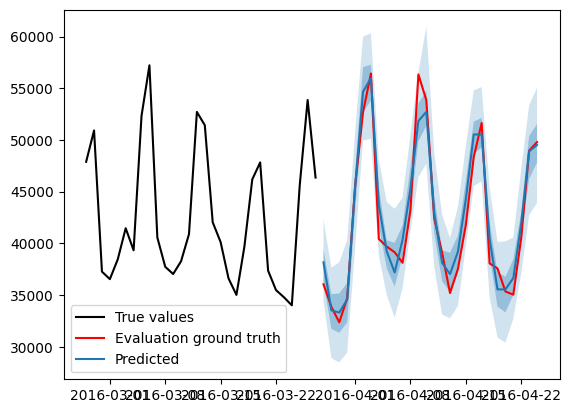

In [41]:
forecasts = list(model.predict(training_data))

# Plot predictions
plt.tight_layout()
plt.plot(training_df.index[-30:], training_df.values[-30:], color="black")
plt.plot(eval_df.index, eval_df.values, color = "red")
# plt.plot(test_df.index, test_df.values, color = "red")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values", "Evaluation ground truth", "Predicted"], loc="lower left")
plt.show()



# Time Series Transformer

In [38]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency("D")
print(lags_sequence)

config = TimeSeriesTransformerConfig(
    prediction_length=28,
    # context length:
    context_length=28 * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)


[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


NameError: name 'time_features' is not defined